In [1]:
import os 
import pandas as pd 
import numpy as np 
from glob import glob
# from scipy import signal, fft
# from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

import scipy.signal
from scipy.signal.windows import hann

import torch
import torchaudio
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import librosa.display
from PIL import Image
import numpy as np

In [82]:
wav_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*.wav')
csv_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*.csv')
len(wav_files), len(csv_files)

(1606, 1607)

In [83]:
# wav_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/311_c.wav')
# csv_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/311_c.csv')

# len(wav_files)

In [84]:
wav_files[0]

'/Users/sehwanyoo/Dropbox/Experiment/datasets/data/56_c.wav'

In [85]:
# --- CSV file 

In [86]:
df = pd.read_csv(csv_files[0])
(
    df.iloc[:, :]
    .T
)

,0,1,2,3
start,0.246254,1.156141,1.476898,1.723744
end,0.281416,1.19202,1.498425,1.756753
fmin,420.195435,175.895767,410.423431,244.299667
fmax,429.967438,214.983719,429.967438,312.703583
category,s,s,s,s


In [87]:
total_category = {} 
for csv in csv_files:
    df = pd.read_csv(csv)
    
    try:
        unique_elements, counts = np.unique(df['category'].astype(str), return_counts=True)
        # element_counts_dict = dict(zip(unique_elements, counts))
        
        for e, c in zip(unique_elements, counts):
            if e in total_category:
                total_category[e] += c
            else:
                total_category[e] = c
    except Exception as e:
        print(e)
            
    # break

total_category
        

'category'


{'s': 3439, 'bc': 103, 'nan': 2714, 'b': 100, 'd': 2, 'a': 34, 'm': 20, 'o': 1}

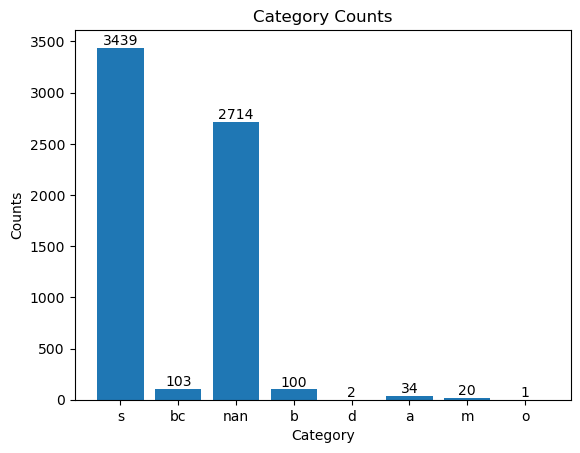

In [88]:
categories = list(total_category.keys())
counts = list(total_category.values())

# 막대 그래프 생성
plt.bar(categories, counts)

for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')


plt.xlabel('Category')  # X축 레이블
plt.ylabel('Counts')    # Y축 레이블
plt.title('Category Counts')  # 그래프 제목
plt.show()

In [71]:
# --- WAV file

In [91]:
def resampling(sig, sample_rate, resample_rate):
    if sample_rate != resample_rate:
        sig = librosa.resample(sig, orig_sr=sample_rate, target_sr=resample_rate)
        sample_rate = resample_rate
        return sig            

    return sig

def normalization(sig):
    return (sig-sig.mean())/sig.std()

def low_pass_filter(wf, sample_rate, high_cut, filter_repetition_count=1):

    waveform = torch.from_numpy(wf)
    for i in range(filter_repetition_count):
        waveform = torchaudio.functional.lowpass_biquad(waveform, sample_rate, cutoff_freq=high_cut, Q=0.707)
    waveform = waveform.numpy()
    return waveform
    

def band_pass_filter(waveform, sample_rate):
    waveform = torch.from_numpy(waveform)
    band_pass_waveform = torchaudio.functional.bandpass_biquad(waveform, sample_rate, central_freq=500, Q=2)
    return waveform.numpy()

In [92]:
class MelSpecto:
    def __init__(self, s_r, o_f, f_n, n_mels=80):
        self.sample_rate = s_r
        self.output_folder = o_f
        self.file_name = f_n
        self.n_mels = n_mels

    def image_save(self, sig, figsize):
        """
        1. n_fft : length of the windowed signal after padding with zeros.

              한 번 fft를 해 줄 만큼의 sequence 길이

        2. hop_length : window 간의 거리 라이브러리 default = 512

        3. win_length : window 길이

        :param sig: wave_form
        :param m_s: max_second
        :return:
        """
        plt.figure(figsize=figsize)
        # n_fft = 512
        # hop_length = 200
        # frame_length = 0.064
        # frame_stride = 0.025
        # n_fft = int(round(self.sample_rate * frame_length))
        # hop_length = int(round(self.sample_rate * frame_stride))

        '''
        win length: 
         - 음성을 작은 조각으로 자를 때 작은 조각의 크기를 의미
         - 자연어 처리 분야에서 25ms의 크기를 기본으로 함 
         - sr / 40
         
        n_fft
         - win_length의 크기로 잘린 음성의 작은 조각은 0으로 패딩되어서 n_fft로 크기가 맞춰짐
         - 패딩된 조각에 푸리에현봔이 적용되기 때문에 n_fft는 win_length보다 크거나 같아야하고 일반적으로 속도를 위해 2의 제곱근으로 설정함
                     
        hop_length
         - 음성을 작은 조각으로 자를 때 자르는 간격을 의미
         - 이 길이 만큼 옆으로 밀면서 작은 조각을 얻음
         - 일반적으로 10ms의 크기를 기본으로 함
         
        n_mels 
         - 적용할 mel filter의 개수를 의미
         
         
         
        우리가 보유한 데이터가 7초이고, window_length를 0.025초, frame_stride를 0.010초(10ms)단위로 뽑는다고 가정하면, 
        1칸은 0.015초(15ms)가 겹치도록 하여 총 700칸을 얻을 수 있다.
        '''
        frame_length = 0.025
        frame_stride = 0.01
        win_length = int(round(self.sample_rate * frame_length))
        n_fft = win_length
        hop_length = int(round(self.sample_rate * frame_stride))
        n_mels_dict = {4000: 64, 8000: 64, 12000: 128, 16000: 128, 20000: 128, 24000: 512}
        n_mels = n_mels_dict[self.sample_rate]
        # fmax = ?

        # display spectrogram
        mel = librosa.feature.melspectrogram(y=np.array(sig), sr=self.sample_rate, n_fft=n_fft, hop_length=hop_length,
                                             win_length=win_length, n_mels=n_mels)
        # , y_axis='mel', x_axis='time'
        librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=self.sample_rate)

        # display spectrogram
        # mel = librosa.feature.melspectrogram(y=np.array(sig), sr=self.sample_rate)
        # # , y_axis='mel', x_axis='time'
        # librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), sr=self.sample_rate)

        plt.savefig(f'{self.output_folder}/{self.file_name}.png', bbox_inches="tight", pad_inches=0)
        plt.plot()
        plt.close()

        # 삭제 말구 잘리는 annotation 부분 지우기
        # img = F.to_pil_image(image)
        # image = Image.open(f'{self.output_folder}/{self.file_name}.png')
        # w, h = image.size
        # # crop을 통해 이미지 자르기       (left,up, rigth, down)
        # croppedImage = image.crop((0, 0, w - 10, h))
        # croppedImage.save(f'{self.output_folder}/{self.file_name}.png')

In [93]:
waveform, sample_rate = torchaudio.load(wav_files[0])
sig, sr = librosa.load(wav_files[0], sr=sample_rate)

In [94]:
len(sig) / sr # 2 seconds

2.0

In [95]:
waveform.shape, sample_rate, sig.shape, sr

(torch.Size([1, 88200]), 44100, (88200,), 44100)

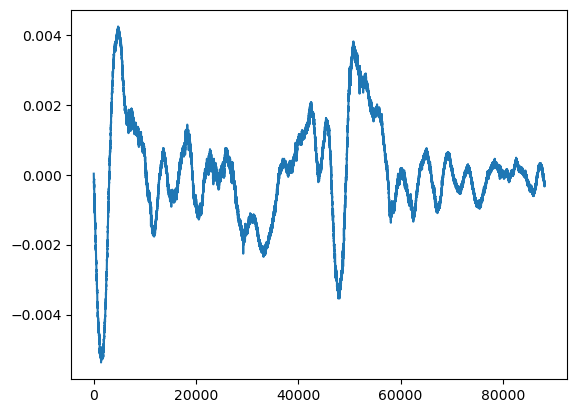

In [96]:
plt.plot(sig)

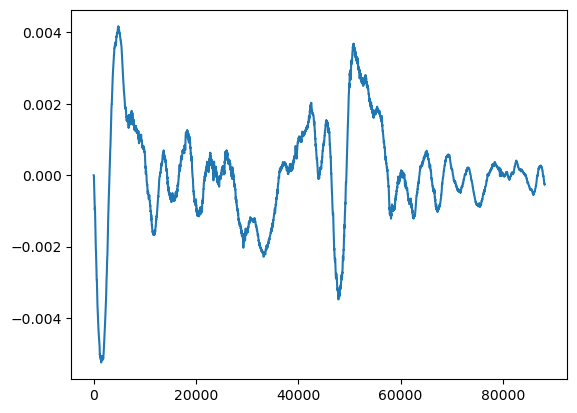

In [97]:
low_pass_filterd_resampled_sig = low_pass_filter(sig, sample_rate=sample_rate, high_cut=500)
# low_pass_filterd_resampled_sig.shape
plt.plot(low_pass_filterd_resampled_sig)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     3 non-null      float64
 1   end       3 non-null      float64
 2   fmin      3 non-null      float64
 3   fmax      3 non-null      float64
 4   category  3 non-null      object 
dtypes: float64(4), object(1)
memory usage: 252.0+ bytes


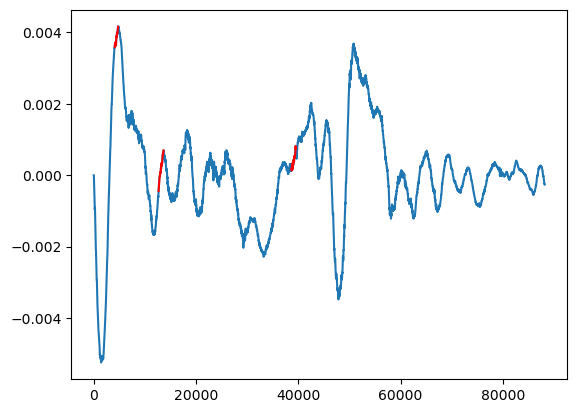

In [99]:
low_pass_filterd_resampled_sig = low_pass_filter(sig, sample_rate=sample_rate, high_cut=500)

plt.plot(low_pass_filterd_resampled_sig)

for idx, val in df.iterrows():
    
    start_time = int(val['start'] * sample_rate)
    end_time = int(val['end'] * sample_rate)
    plt.plot(range(start_time, end_time), low_pass_filterd_resampled_sig[start_time:end_time], color='red')

plt.show()

In [100]:
from IPython.display import Audio
Audio(data=sig, rate=sample_rate)


In [102]:
Audio(data=low_pass_filterd_resampled_sig, rate=sr)


In [105]:
# melspc = MelSpecto()
sig1, sr1 = librosa.load('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/235_a.wav')
low_pass_filterd_resampled_sig1 = low_pass_filter(sig1, sample_rate=sample_rate, high_cut=500)

Audio(data=low_pass_filterd_resampled_sig1, rate=sr1)


In [ ]:
sig2, sr2 = librosa.load('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/235_c.wav')
Audio(data=sig2, rate=sr2)